<center><h1>DeepGlobe Road Extraction - UNET</h1></center>

## 1. `import` Packages

In [ ]:
! pip install patool --quiet
! pip install imgaug --quiet

In [ ]:
import os
import patoolib
import pandas as pd
import cv2 as cv
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa

from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from matplotlib import pyplot as plt
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Conv2DTranspose,
    BatchNormalization,
    Dropout,
    Activation,
    Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint
)

## 2. Load Data

In [ ]:
# ! gdown --id 1--tT1cPD-vbbPXFKrbFvxjsDEzV81B1T

In [ ]:
# patoolib.extract_archive(archive='/content/DeepGlobe_256.zip', outdir='/content/DeepGlobe')

In [ ]:
project_path = '/content/drive/MyDrive/AAIC/SCS-2/deep_globe_road_extraction/'

In [ ]:
file_path = '/content/DeepGlobe/metadata.csv'
df = pd.read_csv(filepath_or_buffer=file_path)

In [ ]:
train_data = df[df['split'] == 'train']
valid_data = df[df['split'] == 'valid']
test_data = df[df['split'] == 'test']

## 3. Data Generator (No Augmentation)

In [ ]:
class Dataset:
    def __init__(self, df):
        self.df = df
        
        # paths of images
        self.sat_images  = self.df['sat_image_path'].to_list()
        # paths of masked images
        self.masks_fps    = self.df['mask_path'].to_list()
    
    def __getitem__(self, i):
        
        # read image directly into RGB format
        image = plt.imread('/content/DeepGlobe/' + self.sat_images[i])
        # read image mask
        image_mask  = plt.imread('/content/DeepGlobe/' + self.masks_fps[i])
        image_mask = image_mask[:,:,0]
            
        return image, image_mask
    
    def __len__(self):
        return len(self.df)

In [ ]:
class DataLoder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

## 4. U-NET Model

Reference → https://youtu.be/GAYJ81M58y8

<center><img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png"></center>

In [ ]:
## Reference → https://youtu.be/GAYJ81M58y8
## The below code is taken from the above video link. Although I have modified it.
## I give full credit to the author of the video and the creators of UNet.

class UNET:
    # convolution block
    def _convolve(self, input_, filters):
        x = Conv2D(filters=filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        x = Conv2D(filters=filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        return x
    
    # up-sampling and convolotion block
    def _convolve_by_upsampling(self, input_, skip_connector, filters, rate):
        x = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_)
        x = concatenate([x, skip_connector])
        x = Dropout(rate)(x)
        x = self._convolve(input_=x, filters=filters)
        return x
    
    # UNET main model 
    def unet_main(self, input_, filters=16, rate=0.05):
        # left encoder Path
        c1 = self._convolve(input_=input_, filters=filters)
        p1 = MaxPooling2D(pool_size=(2, 2))(c1)
        p1 = Dropout(rate)(p1)
        
        c2 = self._convolve(input_=p1, filters=filters * 2)
        p2 = MaxPooling2D(pool_size=(2, 2))(c2)
        p2 = Dropout(rate)(p2)
        
        c3 = self._convolve(input_=p2, filters=filters * 4)
        p3 = MaxPooling2D(pool_size=(2, 2))(c3)
        p3 = Dropout(rate)(p3)
        
        c4 = self._convolve(input_=p3, filters=filters * 8)
        p4 = MaxPooling2D(pool_size=(2, 2))(c4)
        p4 = Dropout(rate)(p4)

        # middle bridge
        c5 = self._convolve(input_=p4, filters=filters * 16)
        
        # right decoder path
        c6 = self._convolve_by_upsampling(input_=c5, skip_connector=c4, filters=filters * 8, rate=rate)
        c7 = self._convolve_by_upsampling(input_=c6, skip_connector=c3, filters=filters * 4, rate=rate)
        c8 = self._convolve_by_upsampling(input_=c7, skip_connector=c2, filters=filters * 2, rate=rate)
        c9 = self._convolve_by_upsampling(input_=c8, skip_connector=c1, filters=filters * 1, rate=rate)
        
        output_ = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(c9)
        
        model = Model(inputs=[input_], outputs=[output_])
        
        return model

Model development

In [ ]:
class Modeling:
    def __init__(self, train_data):
        self.train_data = train_data
    
    def _get_model(self):
        u = UNET()
        inputs = Input(shape=(256, 256, 3))
        model = u.unet_main(input_=inputs)
        return model
    
    def train_model(self, batch_size=32, model_name='unet_scratch', epochs=25, show_performance=True):
        # since the original validation data does not have masks
        # i am considering `1%` of `train_data` as the `custom_validation`
        # in order to keep track of the model's performance
        self.custom_train, self.custom_valid = train_test_split(self.train_data, test_size=0.1, random_state=42)

        train_dataset = Dataset(df=self.custom_train)
        valid_dataset = Dataset(df=self.custom_valid)

        train_dataloader = DataLoder(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dataloader = DataLoder(valid_dataset, batch_size=batch_size, shuffle=True)

        model = self._get_model()
        # callbacks
        model_path = project_path + 'models/{}.h5'.format(model_name)
        model_save_callback = ModelCheckpoint(
            filepath=model_path,
            save_weights_only=True,
            save_best_only=True,
            mode='max',
            monitor='val_accuracy'
        )
        callbacks = [model_save_callback]

        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

        if not os.path.isfile(path=model_path):
            tracker = model.fit(
                x=train_dataloader,
                steps_per_epoch=len(train_dataloader),
                epochs=epochs,
                validation_data=valid_dataloader,
                callbacks=callbacks
            )
            model.load_weights(model_path)

            if show_performance:
                self._plot_performance(tracker=tracker, epochs=len(tracker.history['accuracy']))
        
        else:
            print('Model is already trained and is present in directory.')
            model.load_weights(model_path)
        
        return model
    
    def _plot_xy(self, x, y1, y2, yl, xl='epochs'):
        plt.plot(x, y1, label='train')
        plt.plot(x, y2, label='validation')
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title('Train VS Validation')
        plt.legend()
        plt.show()
        return None
    
    def _plot_performance(self, tracker, epochs):
        x = list(range(1, epochs + 1))

        train_iou = tracker.history['accuracy']
        valid_iou = tracker.history['val_accuracy']

        train_loss = tracker.history['loss']
        valid_loss = tracker.history['val_loss']

        self._plot_xy(x=x, y1=train_iou, y2=valid_iou, yl='accuracy')
        self._plot_xy(x=x, y1=train_loss, y2=valid_loss, yl='loss')

        return None
    
    def plot_custom_valid_performance(self, model, n=10):
        vdata = self.custom_valid.head(n)

        # paths of images
        images_fps   = vdata['sat_image_path'].to_list()
        # paths of masked images
        masks_fps    = vdata['mask_path'].to_list()

        for oimg, mimg in zip(images_fps, masks_fps):
            # original image
            simage = plt.imread('/content/DeepGlobe/' + oimg)

            # mask image
            mimage = plt.imread('/content/DeepGlobe/' + mimg)
            mimage = mimage[:,:,0]

            # prediction
            predicted_image  = model.predict(simage[np.newaxis,:,:,:])
            predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])
            # automatic threshold identification
            pmask_thresh = threshold_otsu(predicted_mask)
            # binarizing the mask
            th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255, type=cv.THRESH_BINARY)
            
            # titles
            image_title = oimg.split('/')[-1]
            mask_title = mimg.split('/')[-1]
            
            # plotting figure
            plt.figure(figsize=(15, 6))
            
            plt.subplot(131)
            plt.axis("off")
            plt.title(image_title)
            plt.imshow(simage)

            plt.subplot(132)
            plt.axis("off")
            plt.title(mask_title)
            plt.imshow(mimage, cmap='gray')

            plt.subplot(133)
            plt.axis("off")
            plt.title("Prediction - {}".format(image_title))
            plt.imshow(predicted_mask, cmap='gray')
            
            plt.show()
        
        return None
    
    def extract_road_path(self, x, model, n=10):
        x_ = x.head(n)

        # paths of images
        images_fps   = x_['sat_image_path'].to_list()
        # paths of masked images
        masks_fps    = x_['mask_path'].to_list()

        for oimg, mimg in zip(images_fps, masks_fps):
            # original image
            simage = plt.imread('/content/DeepGlobe/' + oimg)

            # prediction
            predicted_image  = model.predict(simage[np.newaxis,:,:,:])
            predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])
            # automatic threshold identification
            pmask_thresh = threshold_otsu(predicted_mask)
            # binarizing the mask
            th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255, type=cv.THRESH_BINARY)
            image_title = oimg.split('/')[-1]
            
            plt.figure(figsize=(10, 6))
            
            plt.subplot(121)
            plt.axis("off")
            plt.title(image_title)
            plt.imshow(simage)

            plt.subplot(122)
            plt.axis("off")
            plt.title("Prediction - {}".format(image_title))
            plt.imshow(predicted_mask, cmap='gray')
            
            plt.show()
        
        return None

Object creation

In [ ]:
m = Modeling(train_data=train_data)

Model training

In [ ]:
model = m.train_model()

Model is already trained and is present in directory.


<center><img src="https://user-images.githubusercontent.com/63333753/154027700-c8517c34-1885-416f-ac43-d563072315bd.png"></center>

Valid prediction

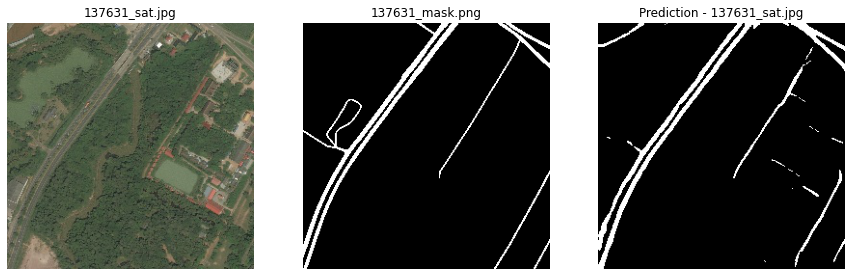

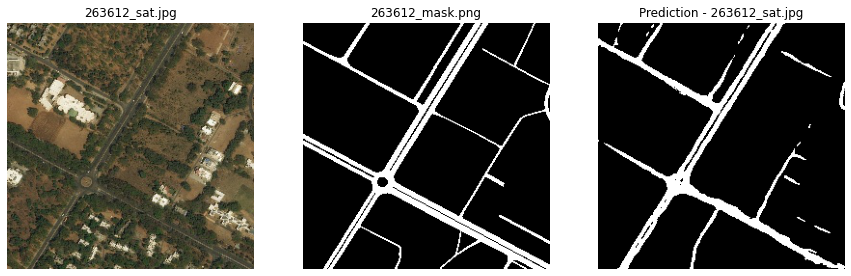

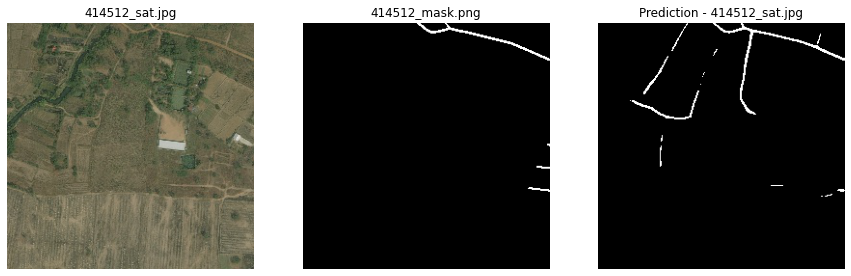

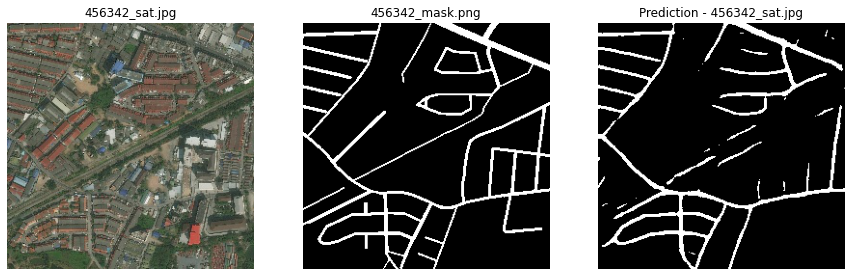

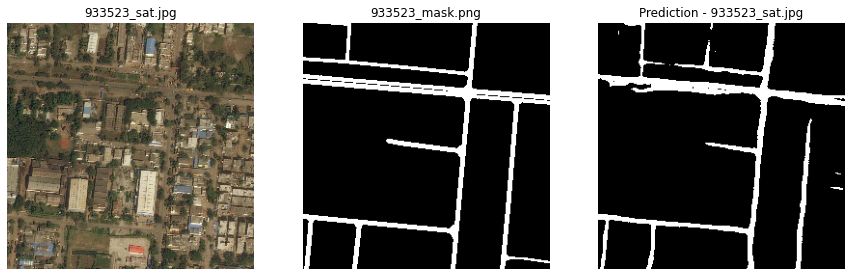

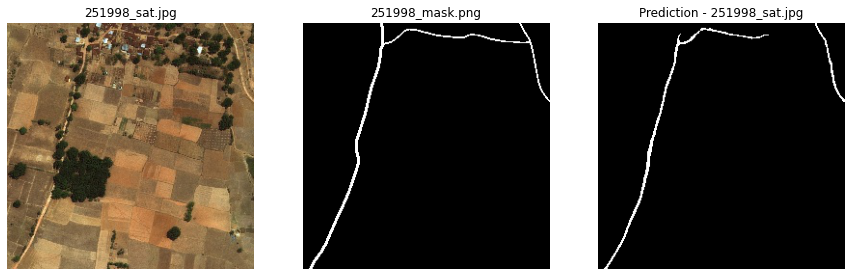

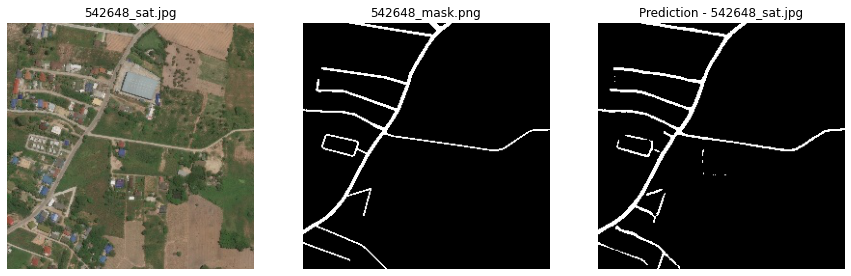

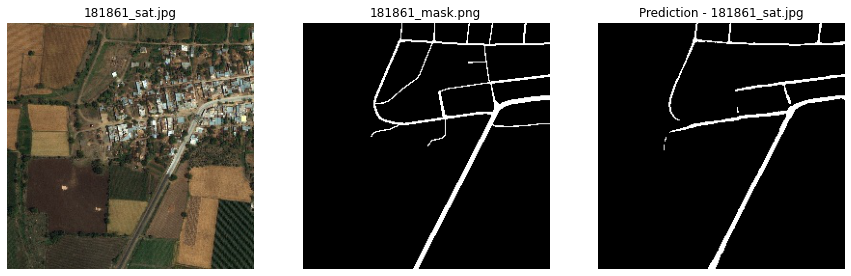

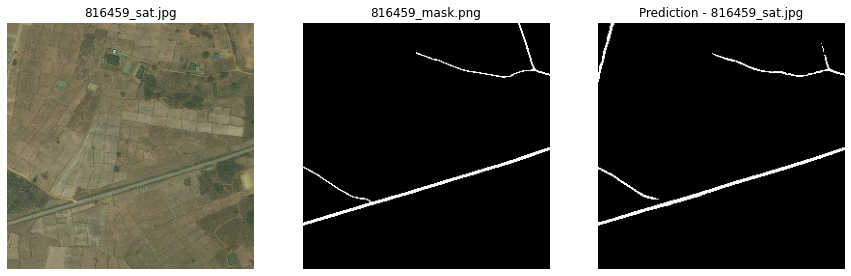

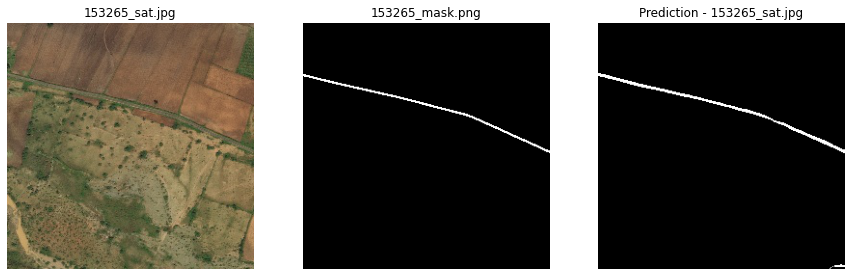

In [ ]:
m.plot_custom_valid_performance(model=model)

Test prediction

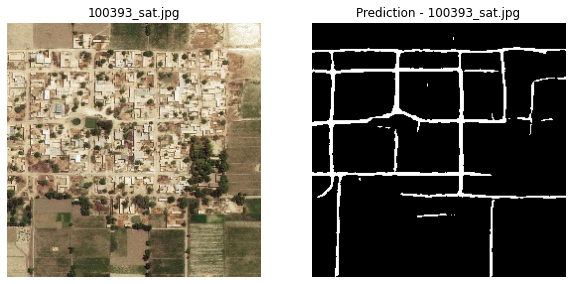

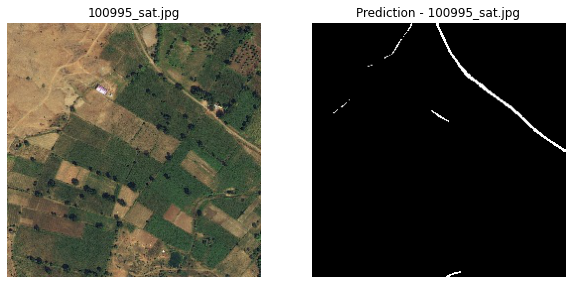

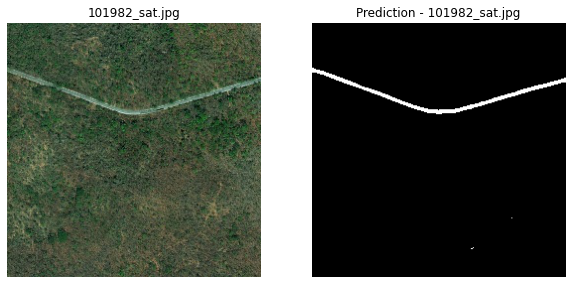

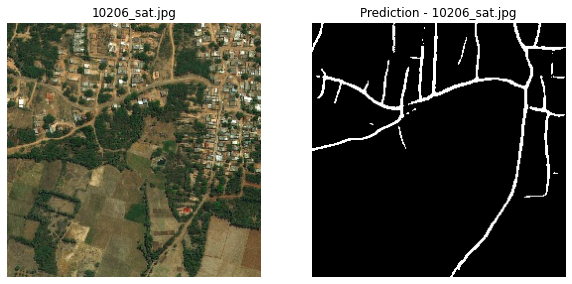

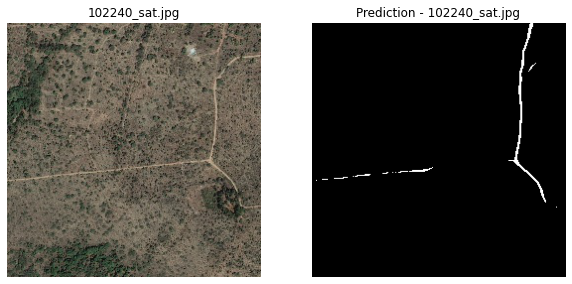

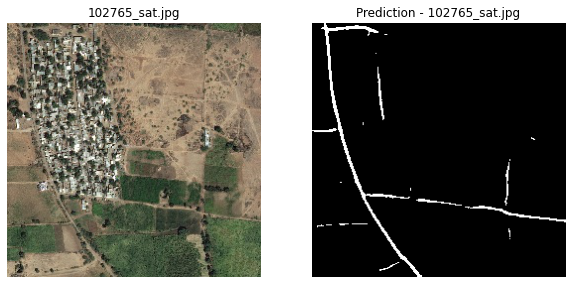

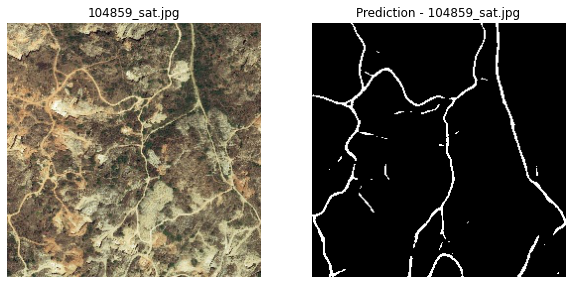

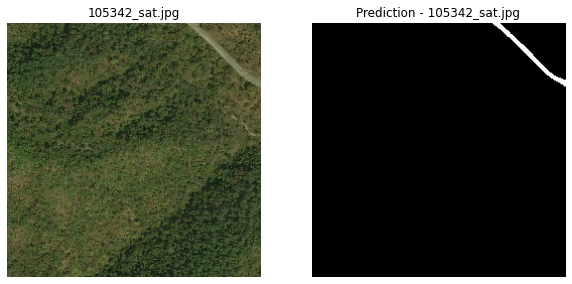

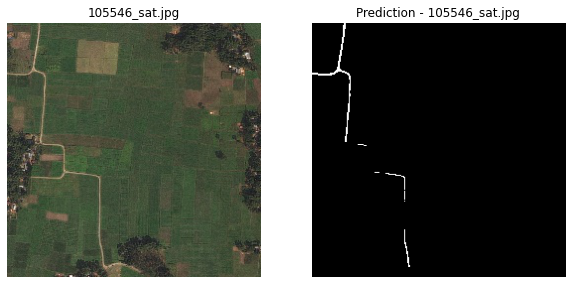

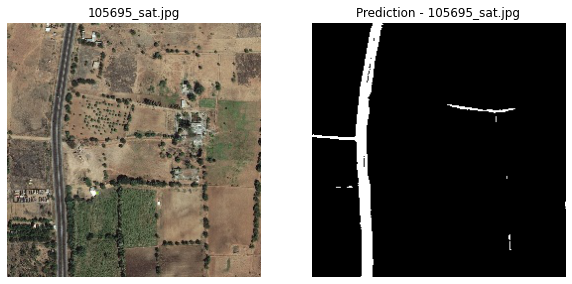

In [ ]:
m.extract_road_path(x=test_data, model=model)

## 5. Data Generator (Augmentation)

Image augmentation

In [ ]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)

In [ ]:
class DatasetAugment:
    def __init__(self, df):
        self.df = df
        
        # paths of images
        self.sat_images  = self.df['sat_image_path'].to_list()
        # paths of masked images
        self.masks_fps    = self.df['mask_path'].to_list()
    
    def __getitem__(self, i):
        
        # read image directly into RGB format
        image = plt.imread('/content/DeepGlobe/' + self.sat_images[i])
        # read image mask
        image_mask  = plt.imread('/content/DeepGlobe/' + self.masks_fps[i])
        image_mask = image_mask[:,:,0]

        a = np.random.uniform()
        if (a <= 0.5):
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        else:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
            
        return image, image_mask
    
    def __len__(self):
        return len(self.df)

Model development

In [ ]:
class ModelingAugmentation:
    def __init__(self, train_data):
        self.train_data = train_data
    
    def _get_model(self):
        u = UNET()
        inputs = Input(shape=(256, 256, 3))
        model = u.unet_main(input_=inputs)
        return model
    
    def train_model(self, batch_size=32, model_name='unet_scratch_augmentated', epochs=25, show_performance=True):
        # since the original validation data does not have masks
        # i am considering `1%` of `train_data` as the `custom_validation`
        # in order to keep track of the model's performance
        self.custom_train, self.custom_valid = train_test_split(self.train_data, test_size=0.1, random_state=42)

        train_dataset = DatasetAugment(df=self.custom_train)
        valid_dataset = DatasetAugment(df=self.custom_valid)

        train_dataloader = DataLoder(train_dataset, batch_size=batch_size, shuffle=True)
        valid_dataloader = DataLoder(valid_dataset, batch_size=batch_size, shuffle=True)

        model = self._get_model()
        # callbacks
        model_path = project_path + 'models/{}.h5'.format(model_name)
        model_save_callback = ModelCheckpoint(
            filepath=model_path,
            save_weights_only=True,
            save_best_only=True,
            mode='max',
            monitor='val_accuracy'
        )
        callbacks = [model_save_callback]

        model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

        if not os.path.isfile(path=model_path):
            tracker = model.fit(
                x=train_dataloader,
                steps_per_epoch=len(train_dataloader),
                epochs=epochs,
                validation_data=valid_dataloader,
                callbacks=callbacks
            )
            model.load_weights(model_path)

            if show_performance:
                self._plot_performance(tracker=tracker, epochs=len(tracker.history['accuracy']))
        
        else:
            print('Model is already trained and is present in directory.')
            model.load_weights(model_path)
        
        return model
    
    def _plot_xy(self, x, y1, y2, yl, xl='epochs'):
        plt.plot(x, y1, label='train')
        plt.plot(x, y2, label='validation')
        plt.xlabel(xl)
        plt.ylabel(yl)
        plt.title('Train VS Validation')
        plt.legend()
        plt.show()
        return None
    
    def _plot_performance(self, tracker, epochs):
        x = list(range(1, epochs + 1))

        train_iou = tracker.history['accuracy']
        valid_iou = tracker.history['val_accuracy']

        train_loss = tracker.history['loss']
        valid_loss = tracker.history['val_loss']

        self._plot_xy(x=x, y1=train_iou, y2=valid_iou, yl='accuracy')
        self._plot_xy(x=x, y1=train_loss, y2=valid_loss, yl='loss')

        return None
    
    def plot_custom_valid_performance(self, model, n=10):
        vdata = self.custom_valid.head(n)

        # paths of images
        images_fps   = vdata['sat_image_path'].to_list()
        # paths of masked images
        masks_fps    = vdata['mask_path'].to_list()

        for oimg, mimg in zip(images_fps, masks_fps):
            # original image
            simage = plt.imread('/content/DeepGlobe/' + oimg)

            # mask image
            mimage = plt.imread('/content/DeepGlobe/' + mimg)
            mimage = mimage[:,:,0]

            # prediction
            predicted_image  = model.predict(simage[np.newaxis,:,:,:])
            predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])
            # automatic threshold identification
            pmask_thresh = threshold_otsu(predicted_mask)
            # binarizing the mask
            th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255, type=cv.THRESH_BINARY)
            
            # titles
            image_title = oimg.split('/')[-1]
            mask_title = mimg.split('/')[-1]
            
            # plotting figure
            plt.figure(figsize=(15, 6))
            
            plt.subplot(131)
            plt.axis("off")
            plt.title(image_title)
            plt.imshow(simage)

            plt.subplot(132)
            plt.axis("off")
            plt.title(mask_title)
            plt.imshow(mimage, cmap='gray')

            plt.subplot(133)
            plt.axis("off")
            plt.title("Prediction - {}".format(image_title))
            plt.imshow(predicted_mask, cmap='gray')
            
            plt.show()
        
        return None
    
    def extract_road_path(self, x, model, n=10):
        x_ = x.head(n)

        # paths of images
        images_fps   = x_['sat_image_path'].to_list()
        # paths of masked images
        masks_fps    = x_['mask_path'].to_list()

        for oimg, mimg in zip(images_fps, masks_fps):
            # original image
            simage = plt.imread('/content/DeepGlobe/' + oimg)

            # prediction
            predicted_image  = model.predict(simage[np.newaxis,:,:,:])
            predicted_mask = predicted_image.reshape(simage.shape[0], simage.shape[1])
            # automatic threshold identification
            pmask_thresh = threshold_otsu(predicted_mask)
            # binarizing the mask
            th, predicted_mask = cv.threshold(src=predicted_mask, thresh=pmask_thresh, maxval=255, type=cv.THRESH_BINARY)
            image_title = oimg.split('/')[-1]
            
            plt.figure(figsize=(10, 6))
            
            plt.subplot(121)
            plt.axis("off")
            plt.title(image_title)
            plt.imshow(simage)

            plt.subplot(122)
            plt.axis("off")
            plt.title("Prediction - {}".format(image_title))
            plt.imshow(predicted_mask, cmap='gray')
            
            plt.show()
        
        return None

Object creation

In [ ]:
ma = ModelingAugmentation(train_data=train_data)

Model training

In [ ]:
model_a = ma.train_model()

Model is already trained and is present in directory.


<center><img src="https://user-images.githubusercontent.com/63333753/154033630-6fd294f2-962f-46d5-91d8-10a71175b00f.png"></center>

Valid prediction

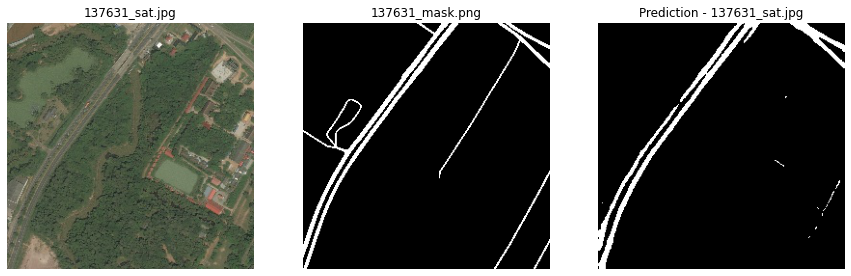

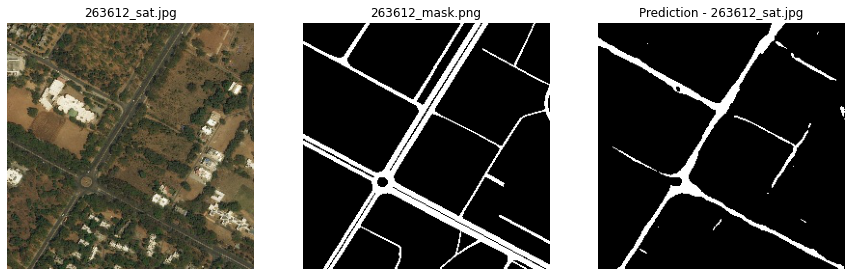

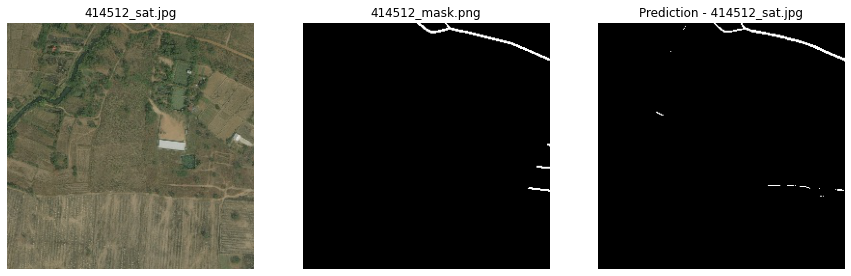

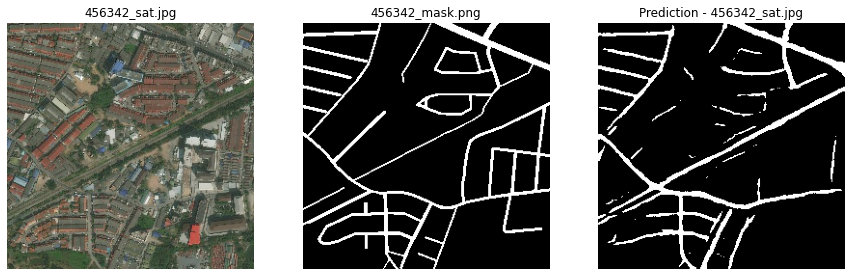

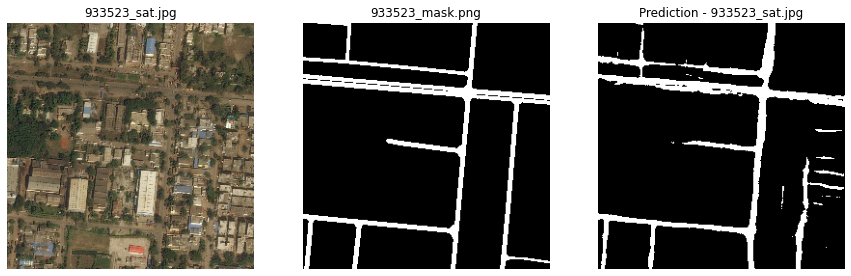

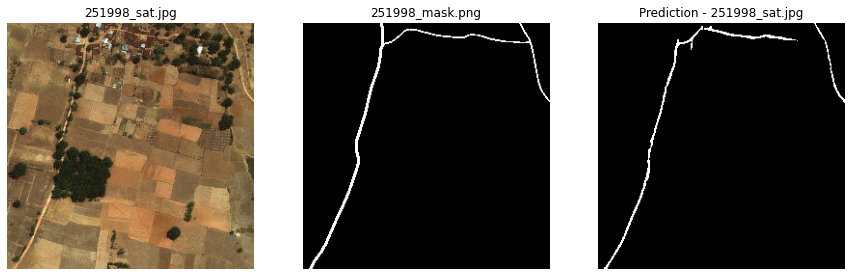

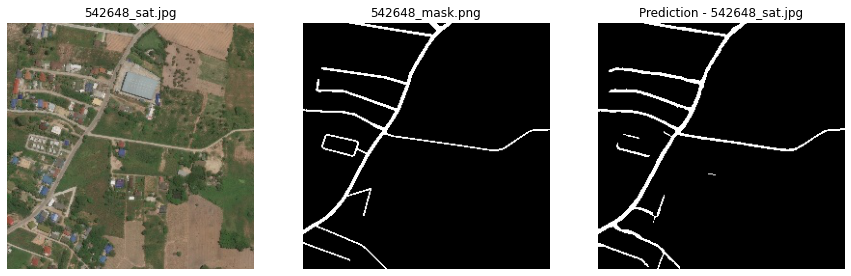

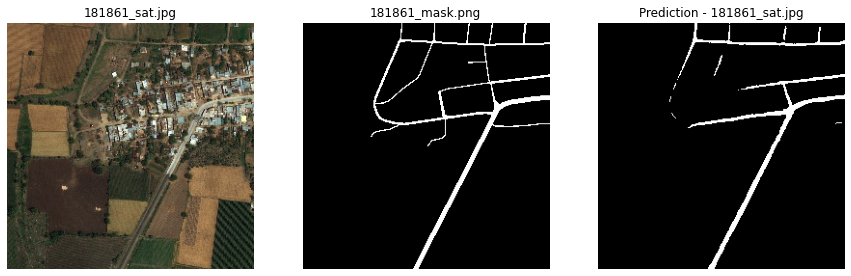

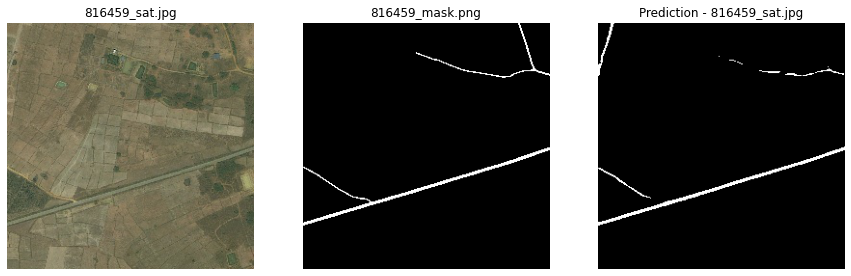

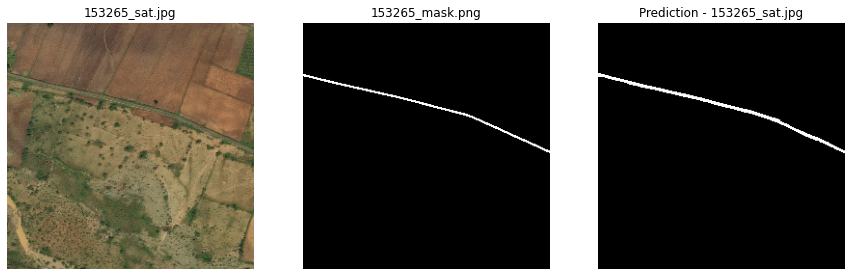

In [ ]:
ma.plot_custom_valid_performance(model=model_a)

Test prediction

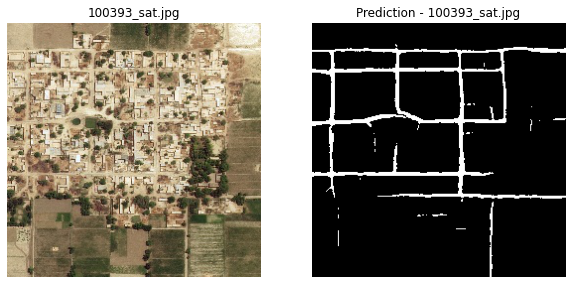

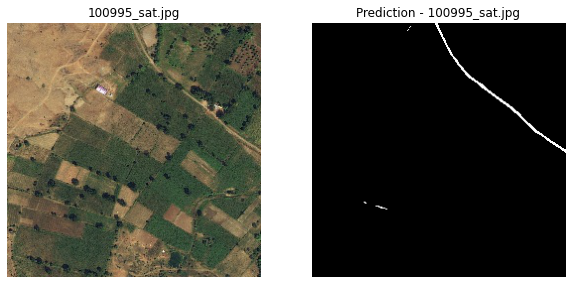

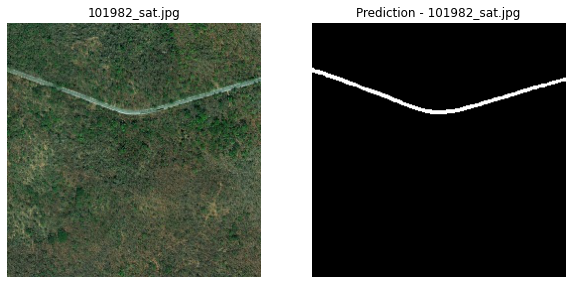

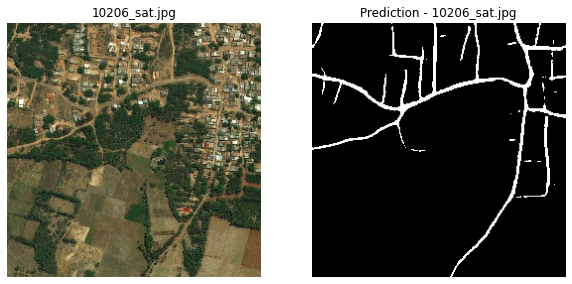

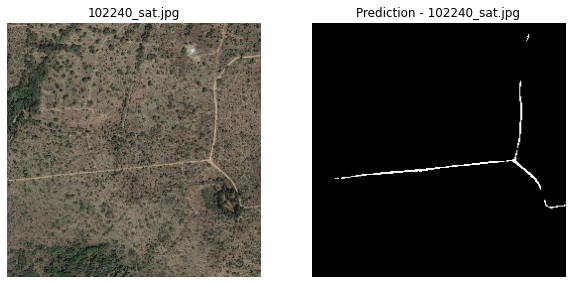

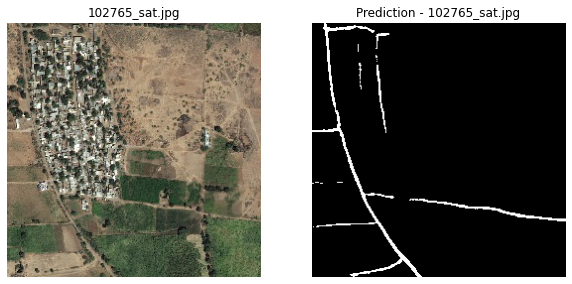

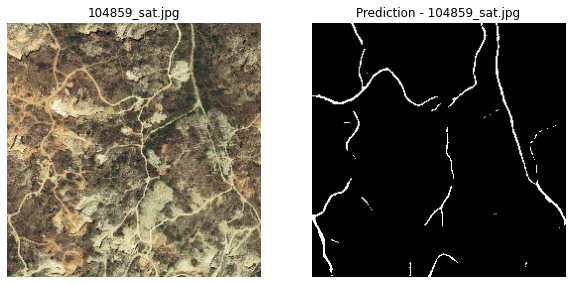

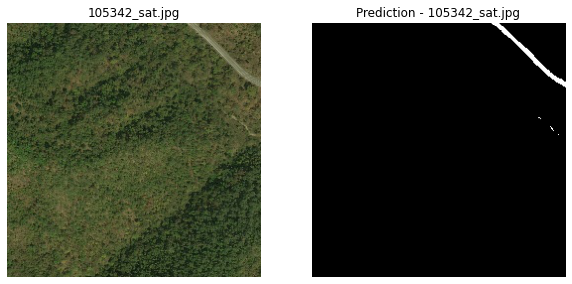

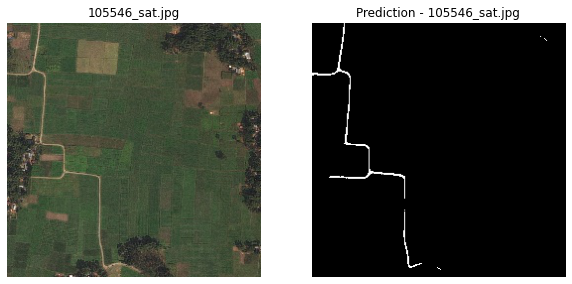

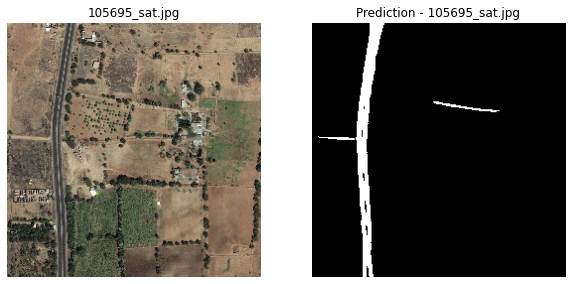

In [ ]:
ma.extract_road_path(x=test_data, model=model_a)

## 6. No Augmentation VS Augmention

* The below are the results obtained by developping the UNET model from scratch.

* The left image corresponds to the results of the model that is trained on the original (no augmentation) data.

* The right image corresponds to the results of the model that is trained on the original (augmented) data.

<center><img src="https://user-images.githubusercontent.com/63333753/154042346-d97c6bf7-3101-4906-a8e1-a46a8f5f1af1.png"></center>

* Clearly by observing the graphs, we can say that left one (model) shows slight overfitting when compared with the right one (model). Although, it seems the difference is negligible.

* Personally, I feel that the model trained on the augmented data does show some closer predictions. This is something we should be observing the process of error analysis.